# EDA #

History:

hour — в какой час пользователь видел объявление;

cpm — цена показанного рекламного объявления в рекламном аукционе. Это значит, что на данном аукционе это была максимальная ставка;

publisher — площадка, на который пользователь увидел рекламу;

user_id — уникальный идентификатор пользователя.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка стиля
#plt.style.use('seaborn')
sns.set_palette("husl")

# Загружаем данные
df_history = pd.read_csv('history.tsv', sep='\t')

# Исследуем структуру данных
print("Информация о датасете:")
df_history.info()

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1147857 entries, 0 to 1147856
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   hour       1147857 non-null  int64  
 1   cpm        1147857 non-null  float64
 2   publisher  1147857 non-null  int64  
 3   user_id    1147857 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 35.0 MB


In [2]:
df_history.head()

,hour,cpm,publisher,user_id
0,10,30.00,1,15661
1,8,41.26,1,8444
2,7,360.00,1,15821
3,18,370.00,1,21530
4,8,195.00,2,22148


In [4]:
#добавим признак преобразованные из часов в часы в сутках
df_history['hour_normalized'] = df_history['hour'] % 24

Users:

user_id — уникальный идентификатор пользователя;

sex — указанный пользователем пол в анкете;

age — указанный пользователем в анкете возраст пользователя. 0 — не указан;

city_id — указанный пользователем в анкете город проживания. 0 — не указан.

In [5]:
# Загружаем данные
df_users = pd.read_csv('users.tsv', sep='\t')

# Исследуем структуру данных
print("Информация о датасете:")
df_users.info()

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27769 entries, 0 to 27768
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   user_id  27769 non-null  int64
 1   sex      27769 non-null  int64
 2   age      27769 non-null  int64
 3   city_id  27769 non-null  int64
dtypes: int64(4)
memory usage: 867.9 KB


In [6]:
df_users.head()

,user_id,sex,age,city_id
0,0,2,19,0
1,1,1,0,1
2,2,2,24,2
3,3,1,20,3
4,4,2,29,4


In [7]:
# Заменяем возраст на 0 для всех, у кого возраст больше 80
df_users.loc[df_users['age'] > 80, 'age'] = 0

In [8]:
# Объединяем датафреймы по столбцу user_id
df_combined = df_history.merge(df_users, on='user_id', how='left')

# Проверяем результат
print("Информация об объединенном датасете:")
df_combined.info()


Информация об объединенном датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1147857 entries, 0 to 1147856
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   hour             1147857 non-null  int64  
 1   cpm              1147857 non-null  float64
 2   publisher        1147857 non-null  int64  
 3   user_id          1147857 non-null  int64  
 4   hour_normalized  1147857 non-null  int64  
 5   sex              1147857 non-null  int64  
 6   age              1147857 non-null  int64  
 7   city_id          1147857 non-null  int64  
dtypes: float64(1), int64(7)
memory usage: 70.1 MB


In [9]:
df_combined.head()

,hour,cpm,publisher,user_id,hour_normalized,sex,age,city_id
0,10,30.00,1,15661,10,2,28,68
1,8,41.26,1,8444,8,1,41,0
2,7,360.00,1,15821,7,1,24,0
3,18,370.00,1,21530,18,2,17,13
4,8,195.00,2,22148,8,1,23,7


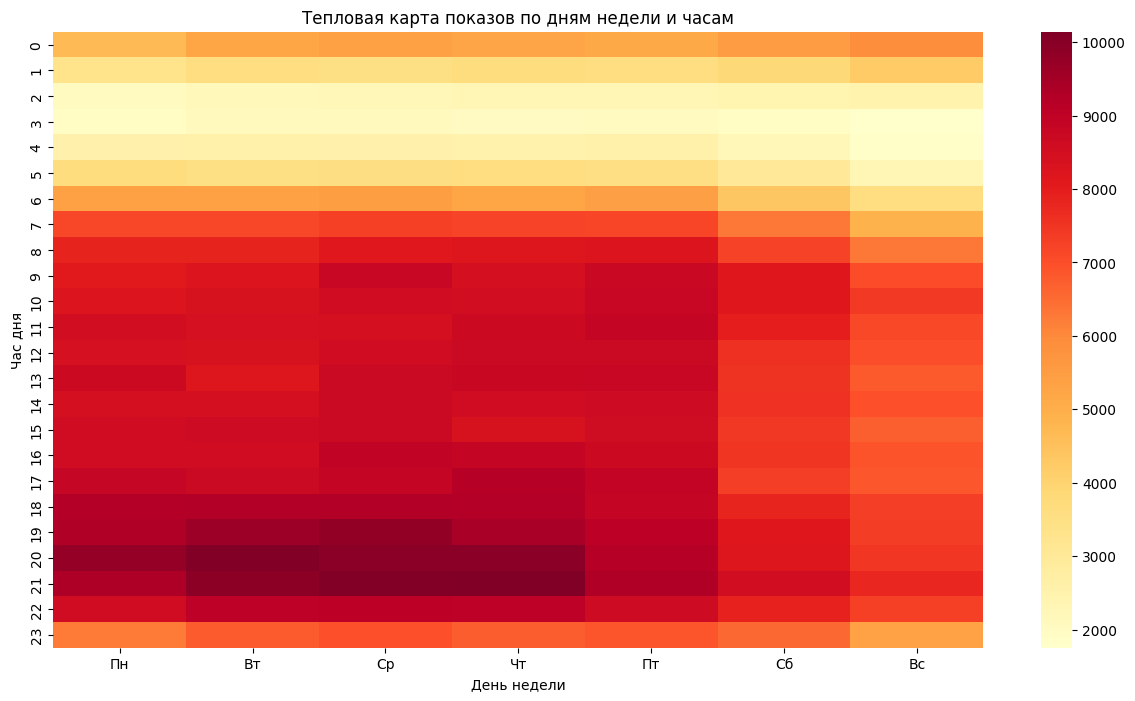

In [10]:
# Добавляем столбец с днями недели (считая от понедельника)
df_combined['weekday'] = df_combined['hour'] // 24  # целочисленное деление на 24 даст нам день недели
df_combined['weekday'] = df_combined['weekday'] % 7  # убеждаемся, что не выходим за пределы недели

# Можно также сделать тепловую карту по дням недели и часам
plt.figure(figsize=(15, 8))
df_combined['hour_of_day'] = df_combined['hour_normalized']
pivot_table = df_combined.pivot_table(
    values='user_id', 
    index='hour_of_day',
    columns='weekday', 
    aggfunc='count'
)
sns.heatmap(pivot_table, 
            cmap='YlOrRd',
            xticklabels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'],
            yticklabels=range(24))
plt.title('Тепловая карта показов по дням недели и часам')
plt.xlabel('День недели')
plt.ylabel('Час дня')
plt.show()

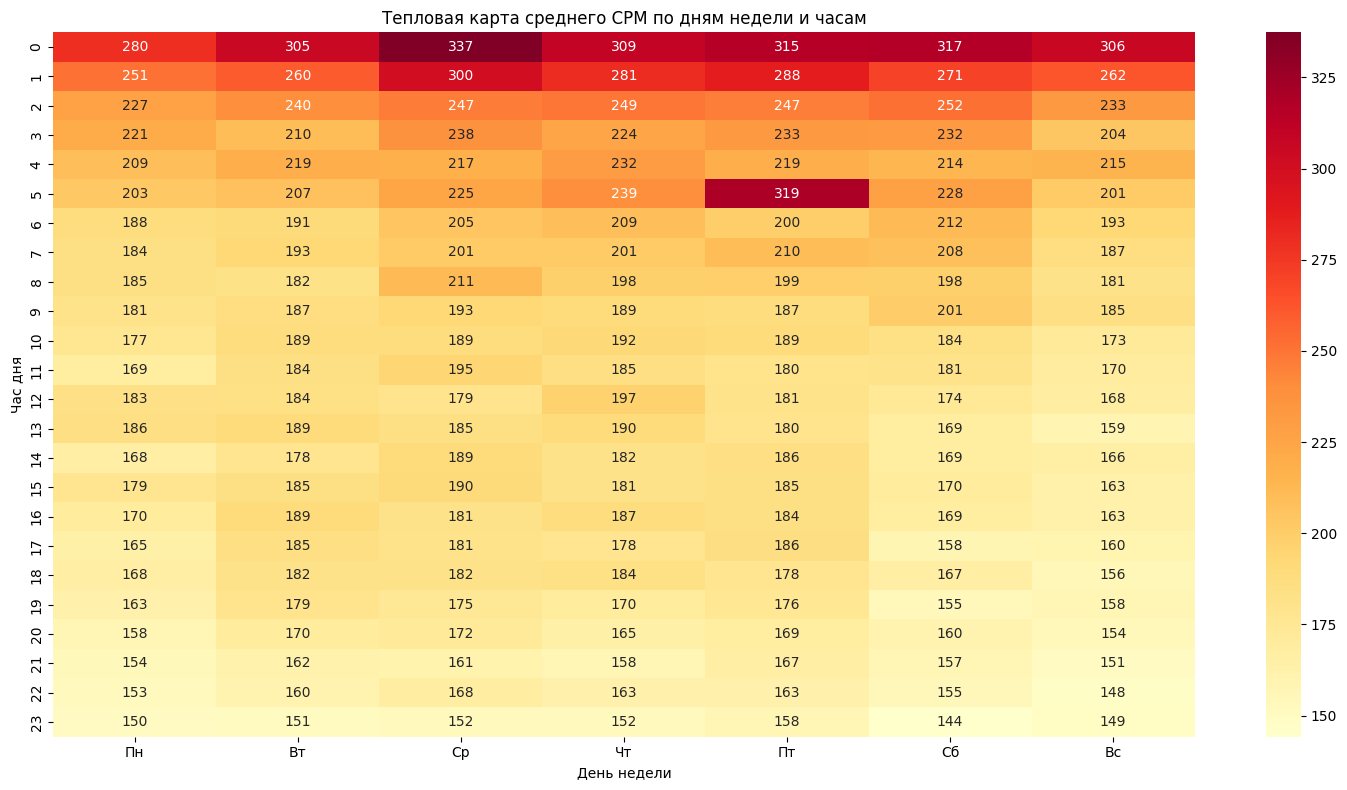

In [11]:
# Создаем тепловую карту
plt.figure(figsize=(15, 8))

# Создаем сводную таблицу со средним CPM
pivot_table = df_combined.pivot_table(
    values='cpm',
    index='hour_normalized',
    columns='weekday',
    aggfunc='mean'
)

# Создаем тепловую карту и сохраняем объект
heatmap = sns.heatmap(
    pivot_table,
    cmap='YlOrRd',  # цветовая схема от желтого к красному
    annot=True,     # показываем значения
    fmt='.0f',      # округляем значения до целых чисел
    xticklabels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'],
    yticklabels=range(24)
)

plt.title('Тепловая карта среднего CPM по дням недели и часам')
plt.xlabel('День недели')
plt.ylabel('Час дня')

# Теперь colorbar добавится автоматически
plt.tight_layout()
plt.show()

C:\Users\Yakov\AppData\Local\Temp\ipykernel_11308\1404727968.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cpm_stats = df_combined.groupby('age_group')['cpm'].agg(['mean', 'count']).round(2)


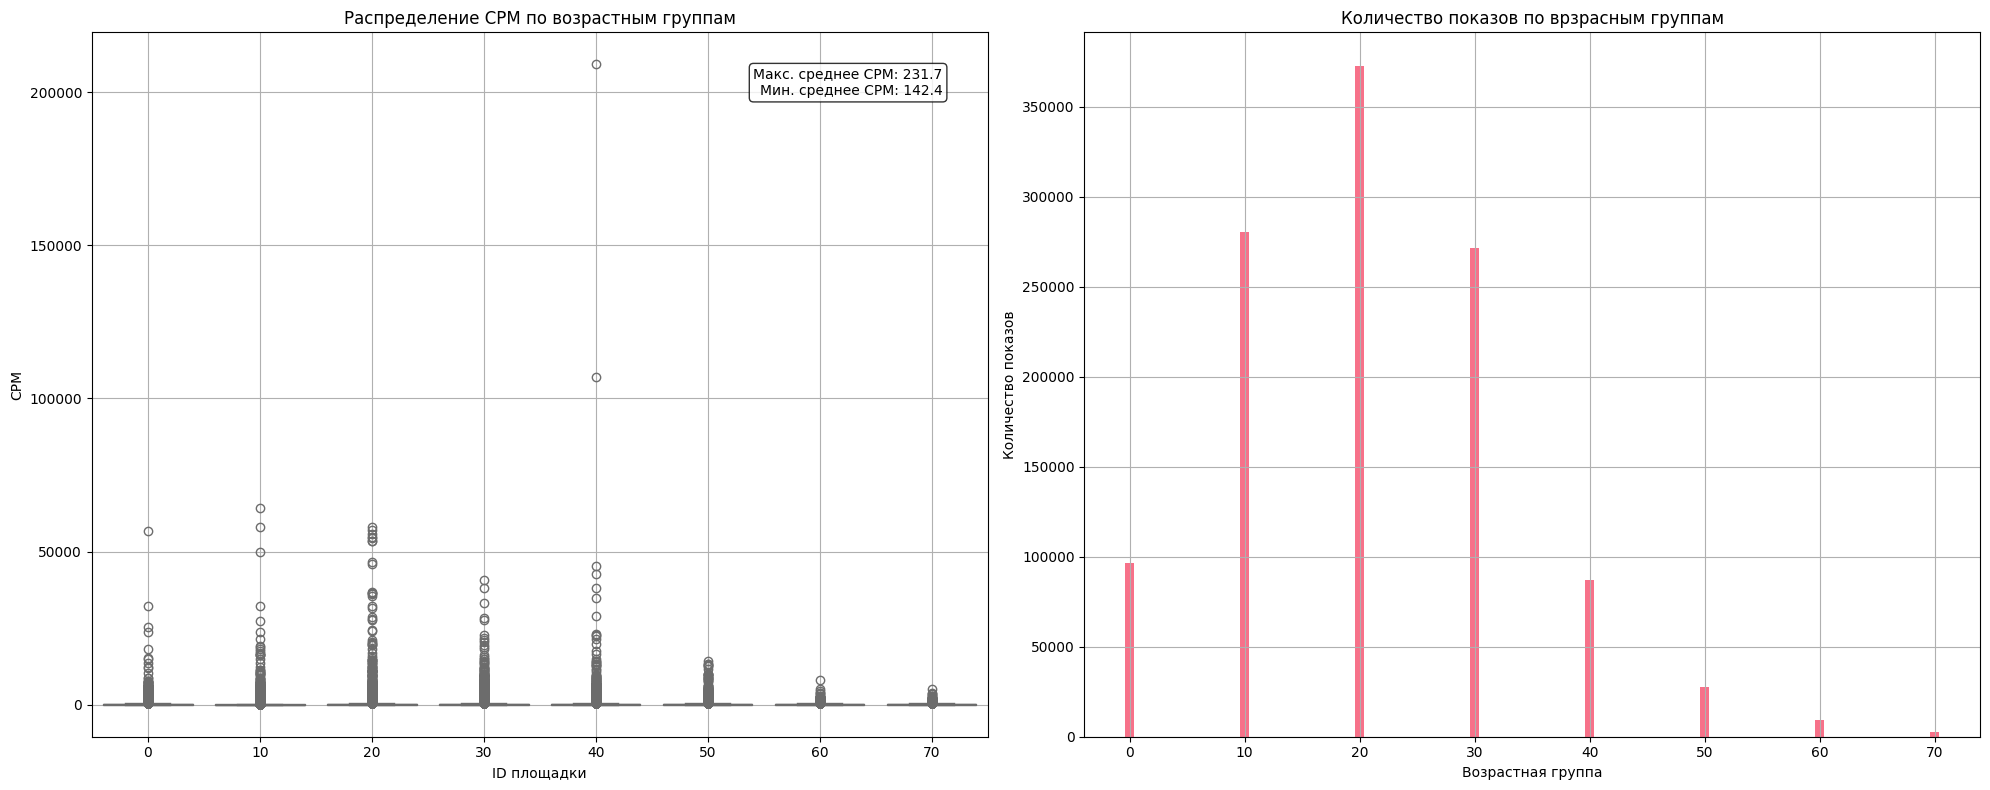

In [12]:
# Создаем возрастные группы по 10 лет
df_combined['age_group'] = pd.cut(df_combined['age'], 
                                bins=[0, 10, 20, 30, 40, 50, 60, 70, 80], 
                                labels=[0, 10, 20, 30, 40, 50, 60, 70],
                                include_lowest=True)

# Создаем подграфики
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# График 1: Среднее CPM по площадкам
sns.boxplot(
    data=df_combined,
    x='age_group',
    y='cpm',
    ax=ax1
)
ax1.set_title('Распределение CPM по возрастным группам')
ax1.set_xlabel('ID площадки')
ax1.set_ylabel('CPM')
ax1.grid(True)

# Добавляем статистику по CPM
cpm_stats = df_combined.groupby('age_group')['cpm'].agg(['mean', 'count']).round(2)
stats_text = f'Макс. среднее CPM: {cpm_stats["mean"].max():.1f}\n'
stats_text += f'Мин. среднее CPM: {cpm_stats["mean"].min():.1f}'
ax1.text(0.95, 0.95, stats_text,
         transform=ax1.transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# График 2: Количество показов по площадкам
age_group_counts = df_combined['age_group'].value_counts().sort_index()
ax2.bar(age_group_counts.index, age_group_counts.values)
ax2.set_title('Количество показов по врзрасным группам')
ax2.set_xlabel('Возрастная группа')
ax2.set_ylabel('Количество показов')
ax2.grid(True)


plt.tight_layout()
plt.show()


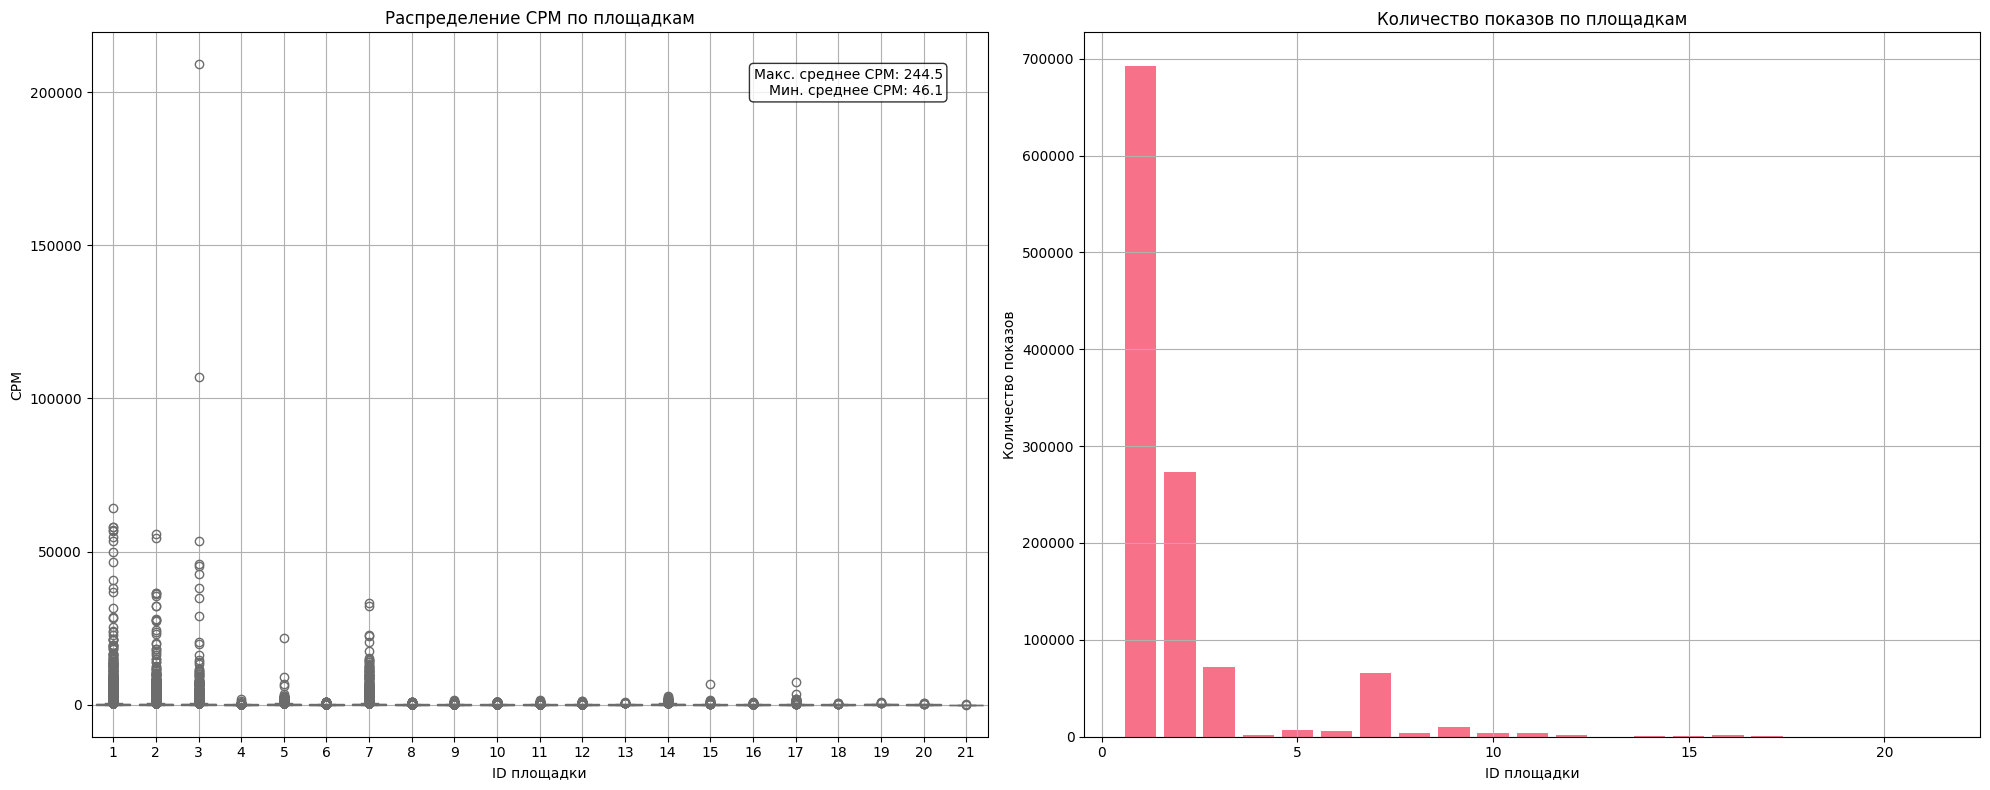

In [13]:
# Создаем подграфики
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# График 1: Среднее CPM по площадкам
sns.boxplot(
    data=df_combined,
    x='publisher',
    y='cpm',
    ax=ax1
)
ax1.set_title('Распределение CPM по площадкам')
ax1.set_xlabel('ID площадки')
ax1.set_ylabel('CPM')
ax1.grid(True)

# Добавляем статистику по CPM
cpm_stats = df_combined.groupby('publisher')['cpm'].agg(['mean', 'count']).round(2)
stats_text = f'Макс. среднее CPM: {cpm_stats["mean"].max():.1f}\n'
stats_text += f'Мин. среднее CPM: {cpm_stats["mean"].min():.1f}'
ax1.text(0.95, 0.95, stats_text,
         transform=ax1.transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# График 2: Количество показов по площадкам
publisher_counts = df_combined['publisher'].value_counts().sort_index()
ax2.bar(publisher_counts.index, publisher_counts.values)
ax2.set_title('Количество показов по площадкам')
ax2.set_xlabel('ID площадки')
ax2.set_ylabel('Количество показов')
ax2.grid(True)



plt.tight_layout()
plt.show()



In [33]:
df_combined.head()

,hour,cpm,publisher,user_id,hour_normalized,sex,age,city_id,weekday,hour_of_day,age_group
0,10,30.00,1,15661,10,2,28,68,0,10,20
1,8,41.26,1,8444,8,1,41,0,0,8,40
2,7,360.00,1,15821,7,1,24,0,0,7,20
3,18,370.00,1,21530,18,2,17,13,0,18,10
4,8,195.00,2,22148,8,1,23,7,0,8,20


In [14]:
df_validate = pd.read_csv('validate.tsv', sep='\t')

# Исследуем структуру данных
print("Информация о датасете:")
df_validate.info()

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cpm            1008 non-null   float64
 1   hour_start     1008 non-null   int64  
 2   hour_end       1008 non-null   int64  
 3   publishers     1008 non-null   object 
 4   audience_size  1008 non-null   int64  
 5   user_ids       1008 non-null   object 
dtypes: float64(1), int64(3), object(2)
memory usage: 47.4+ KB


In [15]:
df_validate.head()

,cpm,hour_start,hour_end,publishers,audience_size,user_ids
0,220.0,1058,1153,"7,17",1906,"12,44,46,50,58,71,93,122,134,143,176,184,187,1..."
1,312.0,1295,1301,"3,18",1380,"29,81,98,102,165,167,195,205,218,231,242,263,3..."
2,70.0,1229,1249,"1,2,3,9,15,21",888,"12,23,25,29,45,85,92,124,156,190,272,334,456,5..."
3,240.0,1295,1377,"1,14",440,"44,122,187,209,242,255,312,345,382,465,513,524..."
4,262.0,752,990,"1,3,7,8",1476,"15,24,30,43,50,53,96,105,159,168,181,190,196,2..."


In [16]:
df_validate_answers = pd.read_csv('validate_answers.tsv', sep='\t')

# Исследуем структуру данных
print("Информация о датасете:")
df_validate_answers.info()

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   at_least_one    1008 non-null   float64
 1   at_least_two    1008 non-null   float64
 2   at_least_three  1008 non-null   float64
dtypes: float64(3)
memory usage: 23.8 KB


In [17]:
df_validate_answers.head()

,at_least_one,at_least_two,at_least_three
0,0.0430,0.0152,0.0073
1,0.0130,0.0000,0.0000
2,0.0878,0.0135,0.0000
3,0.2295,0.1295,0.0727
4,0.3963,0.2785,0.2270


# Модель #

## Подготовка данных ##

In [18]:
def get_user_session_stats(df_combined, user_id):
    """Получает статистику сессий пользователя"""
    user_data = df_combined[df_combined['user_id'] == user_id].sort_values('hour')
    
    # Находим разрывы между показами
    time_gaps = user_data['hour'].diff()
    
    # Сессия заканчивается, если разрыв больше 6 часов
    new_sessions = time_gaps > 6
    
    return {
        'total_impressions': len(user_data),
        'num_sessions': new_sessions.sum() + 1,
        'avg_session_length': len(user_data) / (new_sessions.sum() + 1)
    }

def estimate_view_probability(row, df_combined):
    """Оценивает вероятность просмотра с учетом демографии"""
    parsed = {
        'cpm': row['cpm'],
        'hour_start': row['hour_start'],
        'hour_end': row['hour_end'],
        'publishers': set(map(int, str(row['publishers']).split(','))),
        'audience_size': row['audience_size']
    }
    
    # Фильтруем исторические данные по часам в сутках
    start_hour = parsed['hour_start'] % 24
    end_hour = parsed['hour_end'] % 24
    
    if end_hour < start_hour:  # если период переходит через полночь
        relevant_history = df_combined[
            (df_combined['hour_normalized'] >= start_hour) | 
            (df_combined['hour_normalized'] <= end_hour)
        ]
    else:
        relevant_history = df_combined[
            df_combined['hour_normalized'].between(start_hour, end_hour)
        ]
    
    # Если данных все еще нет, берем все данные
    if len(relevant_history) == 0:
        relevant_history = df_combined
    
    # Базовые метрики по CPM
    higher_bids = (relevant_history['cpm'] > parsed['cpm']).mean()
    equal_bids = (relevant_history['cpm'] == parsed['cpm']).mean()
    
    # Анализ по издателям
    publisher_data = relevant_history[
        relevant_history['publisher'].isin(parsed['publishers'])
    ]
    
    features = {
        # Базовые временные признаки
        'time_window': parsed['hour_end'] - parsed['hour_start'],
        'hour_start_norm': start_hour,
        'hour_end_norm': end_hour,
        'day_of_week': (parsed['hour_start'] // 24) % 7,
        
        # Признаки аукциона
        'cpm': parsed['cpm'],
        'higher_bid_ratio': higher_bids if not np.isnan(higher_bids) else 0,
        'equal_bid_ratio': equal_bids if not np.isnan(equal_bids) else 0,
        
        # Признаки охвата
        'num_publishers': len(parsed['publishers']),
        'audience_size': parsed['audience_size'],
        'avg_publisher_cpm': publisher_data['cpm'].mean() if len(publisher_data) > 0 else 0,
        'publisher_impressions': len(publisher_data),
        
        # Демографические признаки
        'avg_age': relevant_history['age'].mean() if len(relevant_history) > 0 else 0,
        'age_std': relevant_history['age'].std() if len(relevant_history) > 0 else 0,
        'male_ratio': (relevant_history['sex'] == 1).mean() if len(relevant_history) > 0 else 0.5,
        
        # Возрастные группы
        'age_0_18': (relevant_history['age'] <= 18).mean() if len(relevant_history) > 0 else 0,
        'age_19_25': ((relevant_history['age'] > 18) & (relevant_history['age'] <= 25)).mean() if len(relevant_history) > 0 else 0,
        'age_26_35': ((relevant_history['age'] > 25) & (relevant_history['age'] <= 35)).mean() if len(relevant_history) > 0 else 0,
        'age_36_plus': (relevant_history['age'] > 35).mean() if len(relevant_history) > 0 else 0,
        
        # Активность по полу и времени
        'male_morning': ((relevant_history['sex'] == 1) & 
                        (relevant_history['hour_normalized'].between(6, 12))).mean() if len(relevant_history) > 0 else 0,
        'female_morning': ((relevant_history['sex'] == 2) & 
                         (relevant_history['hour_normalized'].between(6, 12))).mean() if len(relevant_history) > 0 else 0,
        'male_evening': ((relevant_history['sex'] == 1) & 
                        (relevant_history['hour_normalized'].between(18, 23))).mean() if len(relevant_history) > 0 else 0,
        'female_evening': ((relevant_history['sex'] == 2) & 
                         (relevant_history['hour_normalized'].between(18, 23))).mean() if len(relevant_history) > 0 else 0,
    }
    
    return features

def prepare_training_data(df_validate, df_combined):
    """Подготовка данных для обучения"""
    features = []
    for _, row in df_validate.iterrows():
        row_features = estimate_view_probability(row, df_combined)
        features.append(row_features)
    
    return pd.DataFrame(features)



In [60]:
# Проверяем
first_row = df_validate.iloc[0]

# Извлекаем признаки для первой строки
features = estimate_view_probability(first_row, df_combined)

features

{'time_window': np.int64(95),
 'hour_start_norm': np.int64(2),
 'hour_end_norm': np.int64(1),
 'day_of_week': np.int64(2),
 'cpm': np.float64(220.0),
 'higher_bid_ratio': np.float64(0.23634738473520656),
 'equal_bid_ratio': np.float64(0.000520099629134988),
 'num_publishers': 2,
 'audience_size': np.int64(1906),
 'avg_publisher_cpm': np.float64(243.3442303172738),
 'publisher_impressions': 67229,
 'avg_age': np.float64(26.123057140392923),
 'age_std': np.float64(12.806856292484552),
 'male_ratio': np.float64(0.5344637877366257),
 'age_0_18': np.float64(0.24561857443915053),
 'age_19_25': np.float64(0.24407657051357443),
 'age_26_35': np.float64(0.3116895223011229),
 'age_36_plus': np.float64(0.19861533274615217),
 'male_morning': np.float64(0.16326598173814333),
 'female_morning': np.float64(0.15655260193560697),
 'male_evening': np.float64(0.1800555295650939),
 'female_evening': np.float64(0.13225166549491793)}

In [59]:
# Разделение выборки

from sklearn.model_selection import train_test_split

# Подготовка данных
X = prepare_training_data(df_validate, df_combined)
y = df_validate_answers

# Разделение на обучающую и тестовую выборки
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Разделение временной выборки на тестовую и валидационную
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

## Функция ошибки ##

In [49]:
def get_smoothed_log_mape_column_value(responses_column, answers_column, epsilon):
    return np.abs(np.log(
        (responses_column + epsilon)
        / (answers_column + epsilon)
    )).mean()


def get_smoothed_mean_log_accuracy_ratio(answers, responses, epsilon=0.005):
    log_accuracy_ratio_mean = np.array(
        [
            get_smoothed_log_mape_column_value(responses.at_least_one, answers.at_least_one, epsilon),
            get_smoothed_log_mape_column_value(responses.at_least_two, answers.at_least_two, epsilon),
            get_smoothed_log_mape_column_value(responses.at_least_three, answers.at_least_three, epsilon),
        ]
    ).mean()

    percentage_error = 100 * (np.exp(log_accuracy_ratio_mean) - 1)

    return percentage_error.round(
        decimals=2
    )


def getsingleerror(answers, responses, epsilon=0.005):
    log_accuracy_ratio_mean = get_smoothed_log_mape_column_value(answers, responses, epsilon)

    percentage_error = 100 * (np.exp(log_accuracy_ratio_mean) - 1)

    return percentage_error

## Обучение и optuna ##

In [54]:
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import optuna.visualization as vis

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10.0),
        'random_seed': 42,
        'verbose': 0
    }
    
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train[target], eval_set=(X_val, y_val[target]), early_stopping_rounds=50)
    
    y_pred = model.predict(X_val)
   
    smoothed_accuracy_ratio = getsingleerror(y_val[target], y_pred)
    return smoothed_accuracy_ratio

# Запускаем для каждого таргета
best_models = {}
for target in ['at_least_one', 'at_least_two', 'at_least_three']:
    study = optuna.create_study(direction='minimize')  # Minimize the percentage error
    study.optimize(objective, n_trials=100)  # You can adjust the number of trials

    # Visualizations
    print(f"Visualizations for {target}:")
    vis.plot_optimization_history(study)
    vis.plot_param_importances(study)
    plt.show()  
    
    # Лучшая модель
    best_params = study.best_params
    best_model = CatBoostRegressor(**best_params)
    best_model.fit(X_train, y_train[target], eval_set=(X_val, y_val[target]), early_stopping_rounds=50)
    
    best_models[target] = best_model
    print(f"Best parameters for {target}: {best_params}")


[I 2024-12-11 23:56:44,324] A new study created in memory with name: no-name-94486c99-0c3b-4583-903a-040f54605397
[I 2024-12-11 23:56:45,693] Trial 0 finished with value: 118.5 and parameters: {'iterations': 694, 'learning_rate': 0.26468566591390985, 'depth': 9, 'l2_leaf_reg': 0.8526499208272614}. Best is trial 0 with value: 118.5.
[I 2024-12-11 23:56:46,329] Trial 1 finished with value: 118.88 and parameters: {'iterations': 377, 'learning_rate': 0.27834390400586667, 'depth': 4, 'l2_leaf_reg': 6.687512307243557}. Best is trial 0 with value: 118.5.
[I 2024-12-11 23:56:47,097] Trial 2 finished with value: 119.18 and parameters: {'iterations': 616, 'learning_rate': 0.2722027591332683, 'depth': 7, 'l2_leaf_reg': 0.8208363566130035}. Best is trial 0 with value: 118.5.
[I 2024-12-11 23:56:47,903] Trial 3 finished with value: 111.66 and parameters: {'iterations': 784, 'learning_rate': 0.14401942356186953, 'depth': 5, 'l2_leaf_reg': 6.370683215637191}. Best is trial 3 with value: 111.66.
[I 20

Visualizations for at_least_one:
0:	learn: 0.1367665	test: 0.1190797	best: 0.1190797 (0)	total: 3.98ms	remaining: 3.68s
1:	learn: 0.1260321	test: 0.1087273	best: 0.1087273 (1)	total: 7.47ms	remaining: 3.45s
2:	learn: 0.1191635	test: 0.1024878	best: 0.1024878 (2)	total: 11ms	remaining: 3.4s
3:	learn: 0.1126215	test: 0.0992547	best: 0.0992547 (3)	total: 14.7ms	remaining: 3.38s
4:	learn: 0.1073730	test: 0.0964753	best: 0.0964753 (4)	total: 18.3ms	remaining: 3.37s
5:	learn: 0.1040425	test: 0.0939601	best: 0.0939601 (5)	total: 22.1ms	remaining: 3.39s
6:	learn: 0.1015683	test: 0.0929782	best: 0.0929782 (6)	total: 25.7ms	remaining: 3.37s
7:	learn: 0.0991795	test: 0.0913889	best: 0.0913889 (7)	total: 29.2ms	remaining: 3.35s
8:	learn: 0.0963566	test: 0.0902931	best: 0.0902931 (8)	total: 32.9ms	remaining: 3.36s
9:	learn: 0.0943946	test: 0.0894617	best: 0.0894617 (9)	total: 35.9ms	remaining: 3.3s
10:	learn: 0.0927575	test: 0.0892701	best: 0.0892701 (10)	total: 38ms	remaining: 3.17s
11:	learn: 0.0

[I 2024-12-11 23:58:51,970] A new study created in memory with name: no-name-ca9ea3fe-ad9d-4482-acc4-dc6063f2189b


Best parameters for at_least_one: {'iterations': 927, 'learning_rate': 0.24954284333570353, 'depth': 5, 'l2_leaf_reg': 8.343589713459023}


C:\Users\Yakov\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

invalid value encountered in log

[I 2024-12-11 23:58:53,373] Trial 0 finished with value: 154.24 and parameters: {'iterations': 244, 'learning_rate': 0.1537608922494537, 'depth': 8, 'l2_leaf_reg': 8.084441097521054}. Best is trial 0 with value: 154.24.
[I 2024-12-11 23:58:54,316] Trial 1 finished with value: 154.24 and parameters: {'iterations': 862, 'learning_rate': 0.19908699469830957, 'depth': 7, 'l2_leaf_reg': 6.389804458639479}. Best is trial 0 with value: 154.24.
[I 2024-12-11 23:58:54,986] Trial 2 finished with value: 163.97 and parameters: {'iterations': 772, 'learning_rate': 0.21497775386513074, 'depth': 4, 'l2_leaf_reg': 0.5133943884486405}. Best is trial 0 with value: 154.24.
[I 2024-12-11 23:58:56,764] Trial 3 finished with value: 153.48 and parameters: {'iterations': 932, 'learning_rate': 0.18449423076125018, 'depth': 8, 'l2_leaf_reg': 5.577269507484254}

Visualizations for at_least_two:
0:	learn: 0.1179062	test: 0.0984266	best: 0.0984266 (0)	total: 19ms	remaining: 11.9s
1:	learn: 0.1162014	test: 0.0968854	best: 0.0968854 (1)	total: 35.1ms	remaining: 11s
2:	learn: 0.1143821	test: 0.0956029	best: 0.0956029 (2)	total: 49ms	remaining: 10.2s
3:	learn: 0.1127936	test: 0.0947103	best: 0.0947103 (3)	total: 58.7ms	remaining: 9.12s
4:	learn: 0.1110342	test: 0.0936898	best: 0.0936898 (4)	total: 68.9ms	remaining: 8.55s
5:	learn: 0.1094536	test: 0.0927480	best: 0.0927480 (5)	total: 78.6ms	remaining: 8.12s
6:	learn: 0.1077634	test: 0.0913267	best: 0.0913267 (6)	total: 87.9ms	remaining: 7.77s
7:	learn: 0.1063488	test: 0.0903295	best: 0.0903295 (7)	total: 97.1ms	remaining: 7.5s
8:	learn: 0.1049939	test: 0.0892609	best: 0.0892609 (8)	total: 107ms	remaining: 7.31s
9:	learn: 0.1038295	test: 0.0885083	best: 0.0885083 (9)	total: 116ms	remaining: 7.15s
10:	learn: 0.1021593	test: 0.0874104	best: 0.0874104 (10)	total: 126ms	remaining: 7.02s
11:	learn: 0.10104

[I 2024-12-12 00:04:32,314] A new study created in memory with name: no-name-d37d5443-b869-43b1-a8d6-146849a0a841


Best parameters for at_least_two: {'iterations': 626, 'learning_rate': 0.056092887921634145, 'depth': 9, 'l2_leaf_reg': 6.636801926665681}


[I 2024-12-12 00:04:34,720] Trial 0 finished with value: 137.25 and parameters: {'iterations': 922, 'learning_rate': 0.21050947691037153, 'depth': 10, 'l2_leaf_reg': 5.21004526731639}. Best is trial 0 with value: 137.25.
[I 2024-12-12 00:04:35,100] Trial 1 finished with value: 193.41 and parameters: {'iterations': 811, 'learning_rate': 0.27755086823251973, 'depth': 6, 'l2_leaf_reg': 3.572755010387679}. Best is trial 0 with value: 137.25.
[I 2024-12-12 00:04:35,645] Trial 2 finished with value: 186.47 and parameters: {'iterations': 320, 'learning_rate': 0.1057637273742808, 'depth': 8, 'l2_leaf_reg': 0.44033929801147165}. Best is trial 0 with value: 137.25.
[I 2024-12-12 00:04:36,025] Trial 3 finished with value: 141.54 and parameters: {'iterations': 471, 'learning_rate': 0.220983395427167, 'depth': 5, 'l2_leaf_reg': 3.4635733709243133}. Best is trial 0 with value: 137.25.
C:\Users\Yakov\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarnin

Visualizations for at_least_three:
0:	learn: 0.0991796	test: 0.0768094	best: 0.0768094 (0)	total: 11.7ms	remaining: 3.36s
1:	learn: 0.0968396	test: 0.0750204	best: 0.0750204 (1)	total: 21.2ms	remaining: 3.04s
2:	learn: 0.0951131	test: 0.0735972	best: 0.0735972 (2)	total: 30ms	remaining: 2.86s
3:	learn: 0.0933220	test: 0.0717805	best: 0.0717805 (3)	total: 38.4ms	remaining: 2.74s
4:	learn: 0.0914951	test: 0.0698097	best: 0.0698097 (4)	total: 46.7ms	remaining: 2.65s
5:	learn: 0.0898956	test: 0.0687220	best: 0.0687220 (5)	total: 53.8ms	remaining: 2.54s
6:	learn: 0.0884224	test: 0.0679863	best: 0.0679863 (6)	total: 59ms	remaining: 2.38s
7:	learn: 0.0865467	test: 0.0664397	best: 0.0664397 (7)	total: 64.1ms	remaining: 2.25s
8:	learn: 0.0851225	test: 0.0655615	best: 0.0655615 (8)	total: 69.7ms	remaining: 2.17s
9:	learn: 0.0837558	test: 0.0644012	best: 0.0644012 (9)	total: 74.7ms	remaining: 2.08s
10:	learn: 0.0823232	test: 0.0632103	best: 0.0632103 (10)	total: 79.8ms	remaining: 2.02s
11:	learn:

In [61]:
# Получаем общую ошибку X_test датасета
responses = pd.DataFrame(index=range(len(X_test)), columns=['at_least_one', 'at_least_two', 'at_least_three'])


for target in ['at_least_one', 'at_least_two', 'at_least_three']:
    y_pred = best_models[target].predict(X_test)
    feature_importances = best_models[target].get_feature_importance()

    responses[target] = np.clip(y_pred, a_min=0, a_max=None)
    
test_accuracy_ratio = get_smoothed_mean_log_accuracy_ratio(y_test, responses)
print(f'Smoothed Mean Log Accuracy Ratio для {target} на тестовом датасете: {test_accuracy_ratio:.2f}%')

responses.to_csv(responces)

Smoothed Mean Log Accuracy Ratio для at_least_three на тестовом датасете: 398.65%
